# Author prediction using RNNs

In this notebook, you will prepare a dataset to predict authorship of the Federalist Papers using Recurrent Neural Networks (RNNs).

## Federalist Papers

The Federalist Papers are a collection of 85 articles and essays written by Alexander Hamilton, James Madison, and John Jay under the pseudonym "Publius". They were published in 1787 and 1788 to promote the ratification of the United States Constitution. The authors of the Federalist Papers wanted to remain anonymous, so they used the pseudonym "Publius". The articles were published in two newspapers, the New York Packet and the Independent Journal. The Federalist Papers are considered important works of American political thought and are still widely read today.

## Additional information

- [Federalist Papers](https://en.wikipedia.org/wiki/The_Federalist_Papers)
- [Federalist Papers dataset](https://www.kaggle.com/datasets/tobyanderson/federalist-papers)
- [LOC Research Guide](https://guides.loc.gov/federalist-papers/full-text)

## Objectives (a)

- Task 1: Design your dataset to predict the author of a text using RNNs.
- Task 2: Explain the methodology of your dataset creation.
- Task 3: Establish a baseline model using Machine Learning algorithms (SVM, Random Forest, etc.).
  
## Objectives (b)

- Task 4: Train a RNN model to predict the author of a text.
- Task 5: Evaluate the performance of your model.
- Task 6: Explain your model architecture, hyperparameters, and the results of your model.

## Task 1: Dataset Creation

### Dataset description

Use the below code to scrape the Library of Congress research guide for the Federalist Papers. You need to pip install the following for the below code to work:

- `pip install beautifulsoup4`
- `pip install requests`
- `pip install pandas`

In [2]:
import pandas as pd
from io import StringIO
from bs4 import BeautifulSoup as bs
import requests

url = 'https://guides.loc.gov/federalist-papers/full-text'

html = requests.get(url).text
soup = bs(html, 'html.parser')

# convert the html table to a pandas dataframe
table = soup.find('table')

# List of Federalist Papers
meta_df = pd.read_html(StringIO(str(table)), parse_dates=True)[0]

### Dataset datatypes

In [3]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   No.          85 non-null     float64
 1   Title        85 non-null     object 
 2   Author       85 non-null     object 
 3   Publication  85 non-null     object 
 4   Date         85 non-null     object 
dtypes: float64(1), object(4)
memory usage: 3.4+ KB


In [4]:
meta_df.head()

,No.,Title,Author,Publication,Date
0,1.0,General Introduction,Hamilton,For the Independent Journal,--
1,2.0,Concerning Dangers from Foreign Force and Infl...,Jay,For the Independent Journal,--
2,3.0,The Same Subject Continued: Concerning Dangers...,Jay,For the Independent Journal,--
3,4.0,The Same Subject Continued: Concerning Dangers...,Jay,For the Independent Journal,--
4,5.0,The Same Subject Continued: Concerning Dangers...,Jay,For the Independent Journal,--


### Autorship counts

Plot the count the number of papers written by each author. We want to create a machine learning dataset that consists of a train, validation, and test set. We will use the train set to train the model, the validation set to tune the hyperparameters, and the test set to evaluate the model.

c:\Users\Yera\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


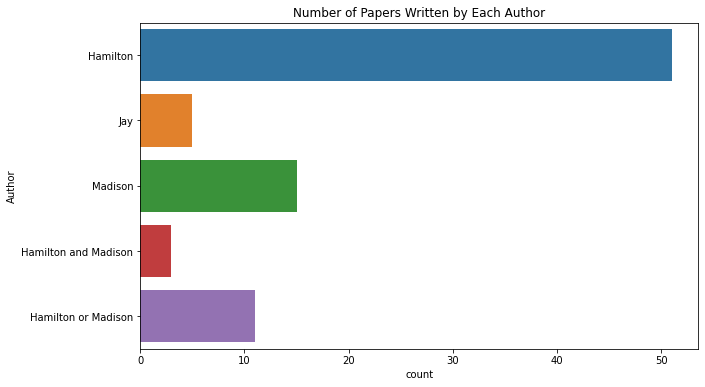

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# plot the number of papers written by each author
plt.figure(figsize=(10, 6))
sns.countplot(y='Author', data=meta_df)
plt.title('Number of Papers Written by Each Author')
plt.show()

Based on the data, answer the following questions:

- How many papers were written by each author?
- How should you construct your dataset? Explain your reasoning.

### Contested authorship

In [6]:
# disputed papers
disputed_papers = meta_df[meta_df['Author'] == 'Hamilton or Madison']
contested_authorship = disputed_papers['No.'].values
print(f'Contested authorship of papers: {contested_authorship}')
print(f'Total number of disputed papers: {len(disputed_papers)}')

Contested authorship of papers: [49. 50. 51. 52. 53. 54. 55. 56. 57. 62. 63.]
Total number of disputed papers: 11


### Load the Federalist Papers corpus

The following code loads the Federalist Papers corpus. The papers have been preprocessed to aid your analysis of the authorship of the papers.

In [7]:
corpus = pd.read_pickle('fp_corpus.pkl')
corpus.head()

,text,paper_id,target,sentences,sentence_length,sentence_index,total_sentences
0,Method of Guarding Against the Encroachments o...,49,dispt,Method of Guarding Against the Encroachments o...,25,0,63
0,Method of Guarding Against the Encroachments o...,49,dispt,"Tuesday, February 5, 1788.",4,1,63
0,Method of Guarding Against the Encroachments o...,49,dispt,Author: Alexander Hamilton or James Madison,6,2,63
0,Method of Guarding Against the Encroachments o...,49,dispt,To the People of the State of New York:,9,3,63
0,Method of Guarding Against the Encroachments o...,49,dispt,"THE author of the ""Notes on the State of Virgi...",56,4,63


The above datasets contains the following columns:

- `paper_id`: The ID of the paper. This corresponds to the number of the paper in the Federalist Papers collection.
- `author`: The author of the paper. This can be one of three values: `Hamilton`, `Madison`, `Jay`, `dispt` (disputed), and `HM` (Hamilton and Madison).
- `text`: The text of the paper.
- `sentence_length`: The token count of the sentence, defined as the number of tokens by splitting the sentence by spaces.
- `sentence_index`: The index of the sentence in the paper.
- `total_sentences`: The total number of sentences in the paper.

The sentences were created by using the Spacy transformer library to split the text of papers into sentences.

In [8]:
# drop the duplicates and keep target and paper_id
authorship = corpus.drop_duplicates(subset=['paper_id', 'target'])
authorship.target.value_counts()

Hamilton    51
Madison     15
dispt       11
Jay          5
HM           3
Name: target, dtype: int64

### Dataset creation

Your task is to predict the author of a paper using the text of the paper. You will use a Recurrent Neural Network (RNN) to predict the author of a paper. You will use the Federalist Papers dataset to train and evaluate your model.

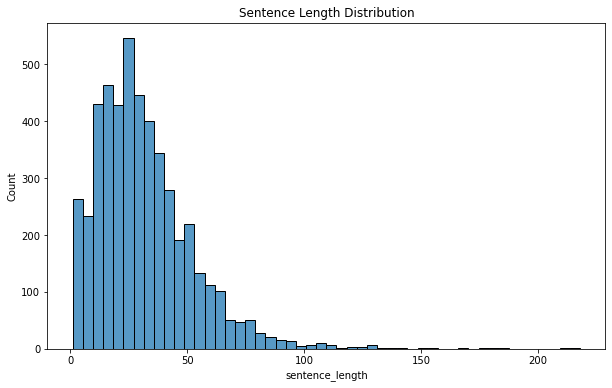

In [9]:
# YOUR CODE HERE - CREATE A DATASET FOR THE CLASSIFICATION TASK OF AUTHORSHIP ATTRIBUTION

# since we want to classify the disputed papers,
# let's remove them from the dataset into their own dataset.

disputed_authors = corpus[corpus['target'] == 'dispt']

# It stands to reason that the disputed papers could be co-authored, so
# let's remove them from the dataset and use them later. Our first task
# is to classify the disputed papers wrt to the question: For any given
# disputed paper, is it more likely to be authored by Hamilton or Madison?

coauthored = corpus[corpus['target'] == 'HM']

# remove the coauthored papers from the dataset
corpus = corpus[corpus['target'] != 'HM']

# since the disputed authors are either Hamilton or Madison, we can
# remove Jay from the dataset. We will hold Jay off for now, but we might
# want to experiment with Jay later.

# create a mask to filter out Jay
jay = corpus[corpus['target'] == 'Jay']

# use the mask to remove jay from the dataset
corpus = corpus[corpus['target'] != 'Jay']

# remove disputed papers from the corpus
corpus = corpus[corpus['target'] != 'dispt']

# plot the sentence length distribution
plt.figure(figsize=(10, 6))
sns.histplot(corpus['sentence_length'], bins=50)
plt.title('Sentence Length Distribution')
plt.show()

### Plot the distribution of the number of papers written by each author.

In [10]:
# YOUR CODE HERE - Visualize the distribution of the sentence lengths (what is the quartile distribution of the sentence lengths?)
import numpy as np

# get the 95th percentile of the sentence length
max_len = np.percentile(corpus['sentence_length'], 95)
max_len

70.0

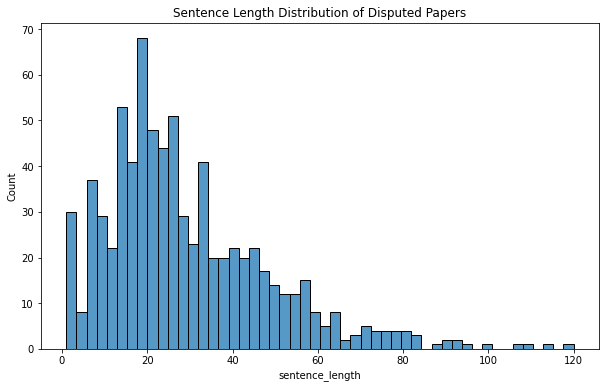

In [11]:
# Plot the sentence distribution of the disputed papers
plt.figure(figsize=(10, 6))
sns.histplot(disputed_authors['sentence_length'], bins=50)
plt.title('Sentence Length Distribution of Disputed Papers')
plt.show();

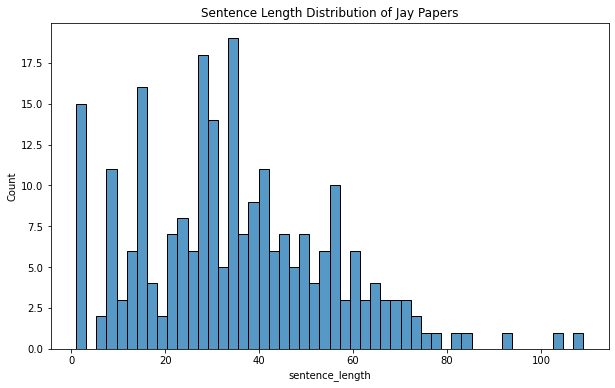

In [12]:
# Plot the sentence distribution of the jay papers
plt.figure(figsize=(10, 6))
sns.histplot(jay['sentence_length'], bins=50)
plt.title('Sentence Length Distribution of Jay Papers')
plt.show();

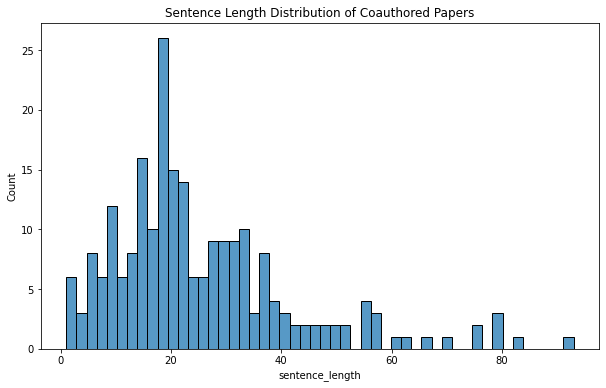

In [13]:
# Plot the sentence distribution of the coauthored papers
plt.figure(figsize=(10, 6))
sns.histplot(coauthored['sentence_length'], bins=50)
plt.title('Sentence Length Distribution of Coauthored Papers')
plt.show();

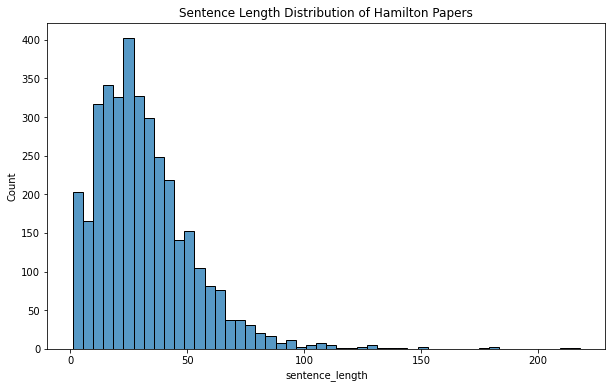

In [14]:
# Plot the sentence distribution of the Hamilton papers
plt.figure(figsize=(10, 6))
sns.histplot(corpus[corpus['target'] == 'Hamilton']['sentence_length'], bins=50)
plt.title('Sentence Length Distribution of Hamilton Papers')
plt.show();

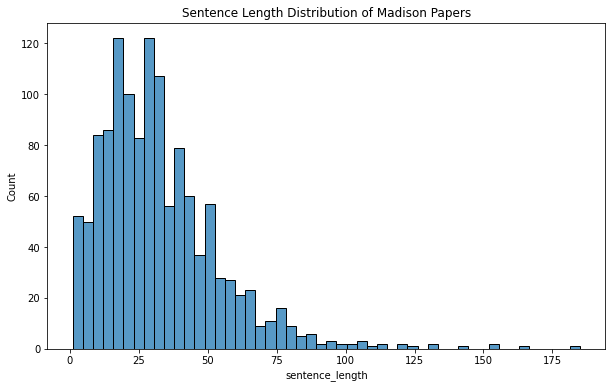

In [15]:
# Plot the sentence distribution of the Madison papers
plt.figure(figsize=(10, 6))
sns.histplot(corpus[corpus['target'] == 'Madison']['sentence_length'], bins=50)
plt.title('Sentence Length Distribution of Madison Papers')
plt.show();

### Plot the distribution of sentence lengths for each author.

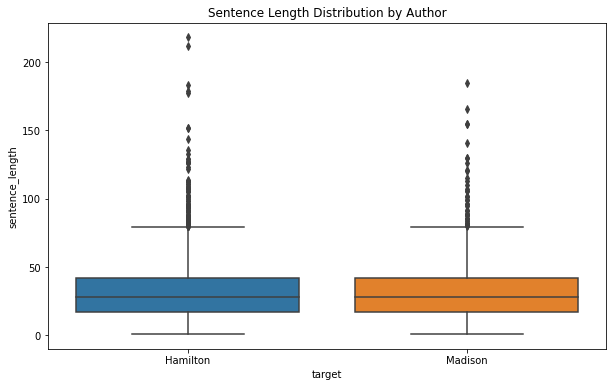

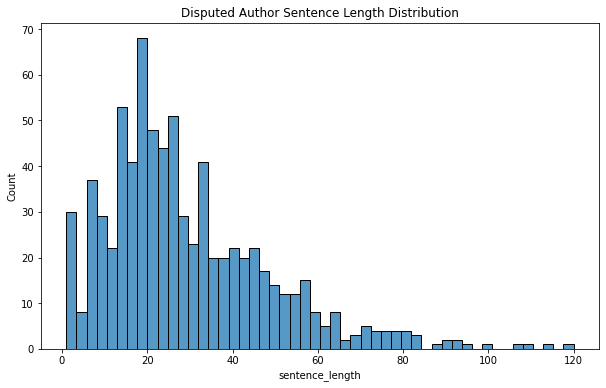

In [16]:
# YOUR CODE HERE - Visualize the distribution of sentence lengths according to the authorship
# plot the sentence length according to the author
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='sentence_length', data=corpus)
plt.title('Sentence Length Distribution by Author')
plt.show()

# plot the disputed_author sentence length and distribution
plt.figure(figsize=(10, 6))
sns.histplot(disputed_authors['sentence_length'], bins=50)
plt.title('Disputed Author Sentence Length Distribution')
plt.show()

### Prepare dataset for training

Prepare a training, validation, and test dataset. What is your X and y? What is the size of your training, validation, and test dataset?

In [17]:
from sklearn.model_selection import train_test_split

X_train, x_val, y_train, y_val = train_test_split(corpus['sentences'],
                                                  corpus['target'],
                                                  test_size=0.2,
                                                  stratify=corpus['target'],
                                                  random_state=42
                                )

print(f'Training samples: {len(X_train)}')
print(f'Validation samples: {len(x_val)}')

Training samples: 3904
Validation samples: 977


#### Visualize some random samples

In [18]:
import random

# sample a random sentence from the training set
random_idx = random.randint(0, len(X_train))
print(f'Random sentence: {X_train.iloc[random_idx]}')
print(f'Author: {y_train.iloc[random_idx]}')

Random sentence: In the case particularly under consideration, there is no such contradiction as appears in the example cited; there is no power on either side to annul the acts of the other.
Author: Hamilton


#### Plot the distribution of training and validation samples

Have you split the dataset in a stratified manner? Explain why it is important to split the dataset in a stratified manner. If you have not, explain why you did not split the dataset in a stratified manner. See the documentation for [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) for more information.

#### Plot the datasets

c:\Users\Yera\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\Yera\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


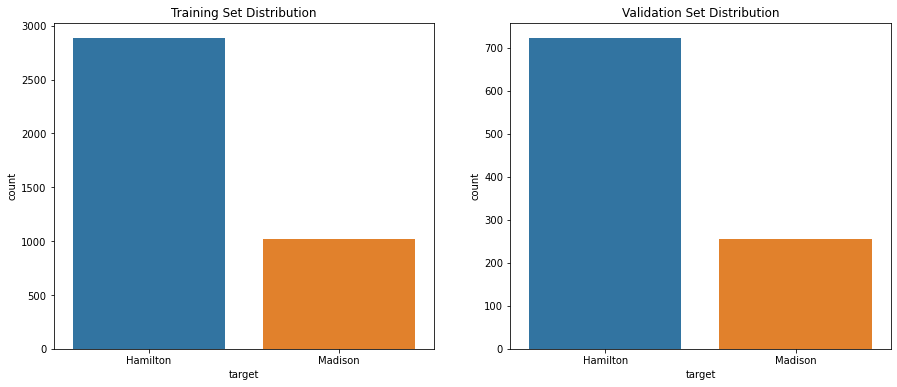

In [19]:
# plot the distribution of the target classes in the training and validation set on a countplot
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
# first plot is the training set
sns.countplot(y_train, ax=ax[0])
ax[0].set_title('Training Set Distribution')
# second plot is the validation set
sns.countplot(y_val, ax=ax[1])
ax[1].set_title('Validation Set Distribution')
plt.show()

#### Convert the target labels to one hot encodings

In [20]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)

y_train_ohe = ohe.fit_transform(y_train.values.reshape(-1, 1))
y_val_ohe = ohe.transform(y_val.values.reshape(-1, 1))

print(f'One hot encoded training labels shape: {y_train_ohe.shape}')
print(f'One hot encoded validation labels shape: {y_val_ohe.shape}')


One hot encoded training labels shape: (3904, 2)
One hot encoded validation labels shape: (977, 2)


In [21]:
y_train_ohe[:5], y_train[:5]

(array([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]]),
 84    Hamilton
 57    Hamilton
 44    Hamilton
 18    Hamilton
 24    Hamilton
 Name: target, dtype: object)

#### Encode the labels

In [22]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_le = label_encoder.fit_transform(y_train)
y_val_le = label_encoder.transform(y_val)

print(f'Label encoded training labels shape: {y_train_le.shape}')
print(f'Label encoded validation labels shape: {y_val_le.shape}')

Label encoded training labels shape: (3904,)
Label encoded validation labels shape: (977,)


In [23]:
for i in range(5):
    print(f'Original label: {y_train.iloc[i]} - Label encoded: {y_train_le[i]}')

Original label: Hamilton - Label encoded: 0
Original label: Hamilton - Label encoded: 0
Original label: Hamilton - Label encoded: 0
Original label: Hamilton - Label encoded: 0
Original label: Hamilton - Label encoded: 0


In [24]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(2, array(['Hamilton', 'Madison'], dtype=object))

## Train a TF-IDF model

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [26]:
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SVC(kernel='linear', C=1.0, random_state=42))
])

# fit the model
text_clf.fit(X_train, y_train_le)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', SVC(kernel='linear', random_state=42))])

In [27]:
text_clf.score(x_val, y_val_le)

0.8085977482088025

In [28]:
# let's use grid search to find the best hyperparameters for the model
from sklearn.model_selection import GridSearchCV

parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__min_df': [1, 5, 10],
    'clf__C': [0.1, 1.0, 15.0]
}

gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, y_train_le)

print(f'{gs_clf.best_params_=}, {gs_clf.best_score_=}')

gs_clf.score(x_val, y_val_le)

gs_clf.best_params_={'clf__C': 15.0, 'tfidf__max_df': 0.5, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}, gs_clf.best_score_=0.8219760990183526


0.8249744114636642

In [29]:
# save the best model
import joblib

joblib.dump(gs_clf, 'authorship_attribution_model.pkl')

['authorship_attribution_model.pkl']

### Explain the TF-IDF model

- What is the TF-IDF model?
- How does the TF-IDF model work?
- What are the hyperparameters of the TF-IDF model?
- How do you select the hyperparameters of the TF-IDF model?
- Why is it helpful to establish a baseline model?

## Inference on the disputed papers

Let's use our model above to predict the authorship of the disputed papers.

In [30]:
# load the model
model = joblib.load('authorship_attribution_model.pkl')

In [31]:
# Run inference on the disputed papers
disputed_predictions = model.predict(disputed_authors['sentences'])

In [32]:
# for a disputed paper plot the predicted probabilities over the classes and sentence order
import matplotlib.pyplot as plt
import seaborn as sns

# add the predicted probabilities to the disputed authors dataframe using the labels
disputed_authors['predicted'] = label_encoder.inverse_transform(disputed_predictions)

# let's plot the authorship classification for the disputed paper 49
dp_49 = disputed_authors[disputed_authors['paper_id'] == '49']

In [33]:
dp_49.head()

,text,paper_id,target,sentences,sentence_length,sentence_index,total_sentences,predicted
0,Method of Guarding Against the Encroachments o...,49,dispt,Method of Guarding Against the Encroachments o...,25,0,63,Hamilton
0,Method of Guarding Against the Encroachments o...,49,dispt,"Tuesday, February 5, 1788.",4,1,63,Madison
0,Method of Guarding Against the Encroachments o...,49,dispt,Author: Alexander Hamilton or James Madison,6,2,63,Madison
0,Method of Guarding Against the Encroachments o...,49,dispt,To the People of the State of New York:,9,3,63,Hamilton
0,Method of Guarding Against the Encroachments o...,49,dispt,"THE author of the ""Notes on the State of Virgi...",56,4,63,Hamilton


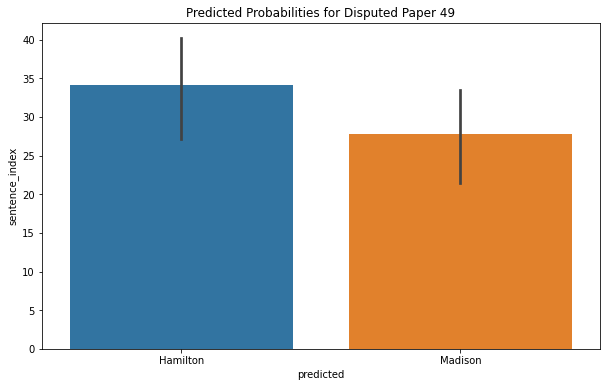

In [34]:
# plot the predicted probabilities for the disputed paper 49
plt.figure(figsize=(10, 6))
sns.barplot(x='predicted', y='sentence_index', data=dp_49)
plt.title('Predicted Probabilities for Disputed Paper 49')
plt.show()

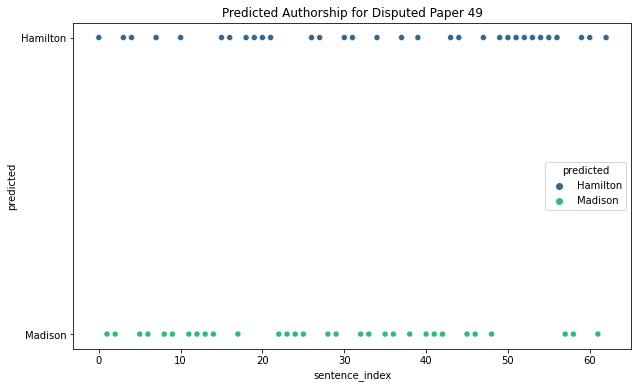

In [35]:
# for each sentence color the predicted author
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sentence_index', y='predicted', data=dp_49, hue='predicted', palette='viridis')
plt.title('Predicted Authorship for Disputed Paper 49')
plt.show()


# Task 2: Train a Recurrent Neural Network (RNN) model

In the second part of this assignment, you are tasked with the following:

- Train a Recurrent Neural Network (RNN) model to predict the author of a paper.
- Evaluate the performance of your model and compare it against the baseline model.
- Explain your model architecture, hyperparameters, and the results of your model.
- Discuss the challenges you faced during the model training process and how you overcame them.
- Classify disputed papers using the Naive Bayes and RNN models
- Write a summary of your findings and the predictions of your model with respect to the disputed papers.

## Train a Recurrent Neural Network (RNN) model

### Vectorize your text data

Vectorize your text data with `tensorflow.keras.models.TextVectorization`. See the documentation here: [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization).

In [36]:
pip install tensorflow

  Using cached ml_dtypes-0.2.0-cp39-cp39-win_amd64.whl (938 kB)

  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2


In [50]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# # YOUR CODE HERE - Create a TextVectorization layer - what arguments will you use? Explain your choice of arguments.

text_vectorizer = TextVectorization()

In [51]:
# Yera's code
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Create a TextVectorization layer
max_vocab_size = 1000  # Maximum vocabulary size
max_sequence_length = 100  # Maximum sequence length
output_sequence_length = 20  # Output sequence length
pad_to_max_tokens = True  # Whether to pad sequences to the max_tokens value

text_vectorizer = TextVectorization(
    max_tokens=max_vocab_size,  # Maximum number of words in the vocabulary
    output_mode='int',  # Output tokens as integers
    output_sequence_length=output_sequence_length,  # Output sequence length
    pad_to_max_tokens=pad_to_max_tokens  # Pad sequences to max_tokens value
)

In [56]:
# Randomly visualize some of your vectorized textual data
import random
example_sent = random.choice(X_train.values) # change var name if you need to
print(f'Original text:\n{example_sent}')
print(f'\nVectorized text:\n{text_vectorizer([example_sent])}')
print('Length of vector:', len(text_vectorizer([example_sent]).numpy()[0]))

Original text:
Pennsylvania may not choose to confound her interests in a connection so adverse to her policy.


FailedPreconditionError: Exception encountered when calling layer 'string_lookup_3' (type StringLookup).

{{function_node __wrapped__LookupTableFindV2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Table not initialized. [Op:LookupTableFindV2] name: 

Call arguments received by layer 'string_lookup_3' (type StringLookup):
  • inputs=<tf.RaggedTensor [[b'pennsylvania', b'may', b'not', b'choose', b'to', b'confound', b'her',
  b'interests', b'in', b'a', b'connection', b'so', b'adverse', b'to',
  b'her', b'policy']]>

In [58]:
example_sent_list = [example_sent]

In [ ]:
# examine the vocabulary
vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in the vocabulary: {len(vocab)}')
print(f'Most common words in the vocabulary: {vocab[:5]}')
print(f'Least common words in the vocabulary: {vocab[-5:]}')

Number of words in the vocabulary: 2
Most common words in the vocabulary: ['', '[UNK]']
Least common words in the vocabulary: ['', '[UNK]']


In [ ]:
# examine the config vars
text_vectorizer.get_config() # when you train your model, these parameters can be changed to perhaps improve performance

{'name': 'text_vectorization_1',
 'trainable': True,
 'dtype': 'string',
 'max_tokens': 1000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 20,
 'pad_to_max_tokens': True,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 2}

In [ ]:
# Adapt the text vectorizer to the training data
text_vectorizer.adapt(YOUR_TRAINING_DATA)

NameError: name 'YOUR_TRAINING_DATA' is not defined

In [59]:
# Adapt the text vectorizer to the training data
text_vectorizer.adapt(X_train)

### Create an embedding layer

In [60]:
token_embedding = tf.keras.layers.Embedding(input_dim=len(vocab),
                                            output_dim=128,
                                            mask_zero=True,
                                            name='token_embedding')

print(f'Sentence before vectorization: {example_sent}')
vectorized_sent = text_vectorizer(example_sent)
print(f'Sentence after vectorization: {vectorized_sent}')
embedded_sent = token_embedding(vectorized_sent)
print(f'Sentence after embedding: {embedded_sent}')

Sentence before vectorization: Pennsylvania may not choose to confound her interests in a connection so adverse to her policy.
Sentence after vectorization: [643  33  21   1   4   1 197 162   6   7   1  60   1   4 197 402   0   0
   0   0]


InvalidArgumentError: Exception encountered when calling layer 'token_embedding' (type Embedding).

{{function_node __wrapped__ResourceGather_device_/job:localhost/replica:0/task:0/device:CPU:0}} indices[0] = 643 is not in [0, 2) [Op:ResourceGather] name: 

Call arguments received by layer 'token_embedding' (type Embedding):
  • inputs=tf.Tensor(shape=(20,), dtype=int64)

In [61]:
# Yera's code - run this to instead of above cell
# Get the vocabulary size from the text_vectorizer
vocab_size = len(text_vectorizer.get_vocabulary())

# Define the Embedding layer with the correct input_dim
token_embedding = tf.keras.layers.Embedding(input_dim=vocab_size,
                                            output_dim=128,
                                            mask_zero=True,
                                            name='token_embedding')

### Create Tensorflow Dataset

To efficiently train your model, you should create a `tf.data.Dataset` object. See the documentation here: [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).

In [ ]:
X_dataset = tf.data.Dataset.from_tensor_slices((YOUR CODE HERE))
val_dataset = tf.data.Dataset.from_tensor_slices((YOUR CODE HERE))

In [62]:
# Yera's code 
X_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_le))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val_le))

In [63]:
# print the first 5 samples
for sample in X_dataset.take(5):
    sentence, label = sample
    print(f'Sentence: {sentence} - Label: {label}')

Sentence: b'We have courts of common law, courts of probates (analogous in certain matters to the spiritual courts in England), a court of admiralty and a court of chancery.' - Label: 0
Sentence: b'Article 3, sec. I. 2.' - Label: 0
Sentence: b'IT IS sometimes asked, with an air of seeming triumph, what inducements could the States have, if disunited, to make war upon each other?' - Label: 0
Sentence: b'It must in truth be acknowledged that, however these may differ in other respects, they in general appear to harmonize in this sentiment, at least, that there are material imperfections in our national system, and that something is necessary to be done to rescue us from impending anarchy.' - Label: 0
Sentence: b'Pennsylvania and North Carolina are the two which contain the interdiction in these words: "As standing armies in time of peace are dangerous to liberty, THEY OUGHT NOT to be kept up."' - Label: 0


### Create batches of data

Batch size is a model hyperparameter that defines the number of samples that will be propagated through the network. This number can and should be adjusted in consideration with model performance and compute memory. See the documentation here: [Batch size](https://www.tensorflow.org/guide/data).

In [64]:
BATCH_SIZE = #YOUR CODE HERE

In [ ]:
# Yera's Code
BATCH_SIZE = 32

In [65]:
train_dataset = X_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

QUESTION: What does tf.data.AUTOTUNE do?

### Design your model

In [66]:
# MODEL Hyperparameters
learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = 'categorical_crossentropy'
epochs = 8

In [68]:
# Model architecture
from tensorflow.keras import layers, regularizers

# inputs = tf.keras.layers.Inputs(shape=(1,), dtype=tf.string)

# Yera's code - run this instead of above line
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

x = text_vectorizer(inputs)
# YOUR ADDITIONAL LAYERS HERE
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [69]:
# Train the model or fit the model on the data
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

Epoch 1/8


ValueError: in user code:

    File "c:\Users\Yera\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Yera\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Yera\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Yera\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\Yera\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "c:\Users\Yera\anaconda3\lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\Yera\anaconda3\lib\site-packages\keras\src\losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\Yera\anaconda3\lib\site-packages\keras\src\losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\Yera\anaconda3\lib\site-packages\keras\src\losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "c:\Users\Yera\anaconda3\lib\site-packages\keras\src\backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 2) are incompatible


In [71]:
# Yera's code - run this instead of above
from tensorflow.keras import layers

# Model architecture
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
# Additional layers
outputs = layers.Dense(2, activation='softmax')(x)  # Two units for binary classification
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)


Epoch 1/8



122/122 [==============================] - 2s 7ms/step - loss: 109.7135 - accuracy: 0.5961 - val_loss: 88.7223 - val_accuracy: 0.6131
Epoch 2/8
122/122 [==============================] - 0s 4ms/step - loss: 80.7781 - accuracy: 0.6104 - val_loss: 62.4715 - val_accuracy: 0.6356
Epoch 3/8
122/122 [==============================] - 0s 4ms/step - loss: 53.8785 - accuracy: 0.6212 - val_loss: 38.3930 - val_accuracy: 0.6448
Epoch 4/8
122/122 [==============================] - 0s 4ms/step - loss: 29.1254 - accuracy: 0.6253 - val_loss: 16.5384 - val_accuracy: 0.6479
Epoch 5/8
122/122 [==============================] - 0s 4ms/step - loss: 8.3824 - accuracy: 0.6209 - val_loss: 1.0406 - val_accuracy: 0.6847
Epoch 6/8
122/122 [==============================] - 0s 4ms/step - loss: 0.7737 - accuracy: 0.6578 - val_loss: 0.7545 - val_accuracy: 0.7206
Epoch 7/8
122/122 [==============================] - 1s 5ms/step - loss: 0.7443 - accuracy: 0.6652 - val_loss: 0.7620 - val_accuracy: 0.7206
Epoch 8/8
122

QUESTION: How can tensorflow automatically save the best performing model for you?

## Evaluate the performance of your model

In [72]:
# plot the training history
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

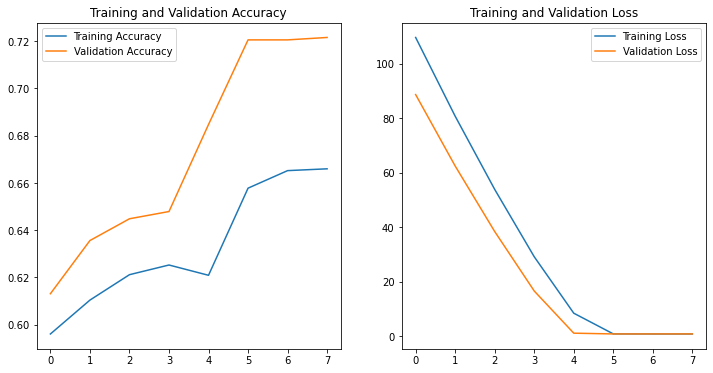

In [73]:
plot_history(history)

- QUESTION: Is your model overfit? Underfit?
- QUESTION: Explain how bias and variance relate to training your model?

## Explain your model architecture, hyperparameters, and the results of your model

- QUESTION: What hyperparameters resulted in the best performing model?
- QUESTION: What parameters resulted in the best performing model?
- QUESTION: What model architecture resulted in the best performing model?

## Challenges faced during the model training process

Please explain any challenges you faced and how you overcame them.

## Classify the disputed authorship data

Using the Naive Bayes and RNN models, classify the disputed author sentences. Use visuaulizations and confusion matrices to communicate the decision outputs of your models. Are there any trends?

In [ ]:
# YOUR CODE HERE

In [79]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import matplotlib.pyplot as plt
import seaborn as sns

# Vectorize the training data
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
x_val_vec = vectorizer.transform(x_val)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Convert the encoded labels to categorical for the RNN
y_train_categorical = tf.keras.utils.to_categorical(y_train_encoded)
y_val_categorical = tf.keras.utils.to_categorical(y_val_encoded)


Naive Bayes Model Accuracy: 0.8034800409416581


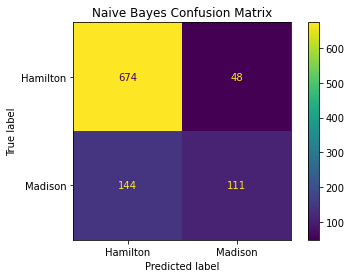

In [84]:
# Create and train the Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train_encoded)

# Evaluate the model on the validation data
nb_score = nb_model.score(x_val_vec, y_val_encoded)
print(f'Naive Bayes Model Accuracy: {nb_score}')

# Predictions for Naive Bayes
nb_predictions = nb_model.predict(x_val_vec)

# Confusion Matrix for Naive Bayes
nb_cm = confusion_matrix(y_val_encoded, nb_predictions)
nb_cm_display = ConfusionMatrixDisplay(nb_cm, display_labels=label_encoder.classes_).plot()
plt.title('Naive Bayes Confusion Matrix')
plt.show()


In [86]:
# Define the RNN model
rnn_model = Sequential([
    Embedding(input_dim=X_train_vec.shape[1], output_dim=128, input_length=X_train_vec.shape[1]),
    LSTM(64),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 7348, 128)         940544    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 990082 (3.78 MB)
Trainable params: 990082 (3.78 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Summary of your findings and predictions

- Classify the undetermined sentences with the Naive Bayes Model and your RNN model. Compare and contrast the results.
- What are your conclusions based on your experiments?
- Describe how a data science NLP solution relates to other methdologies for addressing author identification. Can we and should we value the RNN outputs? How does our RNN solution relate to issues of human values, judgments, and biases of opinion?

## Extra credit

Go back to your dataset creation and randomly change the author of the assigned sentence. With the labels randomized, rerun the code above. Describe what you learned in this process. (2pts to final grade)

In [88]:
import random
import tensorflow as tf

# Function to randomly change the author of the assigned sentence
def randomize_authorship(data):
    randomized_data = data.copy()
    for i in range(len(randomized_data)):
        if randomized_data['target'].iloc[i] != 'dispt':
            authors = ['HM', 'Madison', 'Jay']
            if randomized_data['target'].iloc[i] in authors:
                authors.remove(randomized_data['target'].iloc[i])
                randomized_data['target'].iloc[i] = random.choice(authors)
    return randomized_data

# Randomize authorship in the corpus
corpus_randomized = randomize_authorship(corpus)

# Separate the randomized corpus into training and validation sets
X_train_randomized, x_val_randomized, y_train_randomized, y_val_randomized = train_test_split(
    corpus_randomized['sentences'], corpus_randomized['target'], test_size=0.2, stratify=corpus_randomized['target'], random_state=42
)

# Vectorize the training data
X_train_randomized_vec = vectorizer.fit_transform(X_train_randomized)
x_val_randomized_vec = vectorizer.transform(x_val_randomized)

# Encode labels
y_train_randomized_encoded = label_encoder.fit_transform(y_train_randomized)
y_val_randomized_encoded = label_encoder.transform(y_val_randomized)

# Convert the encoded labels to categorical for the RNN
y_train_randomized_categorical = tf.keras.utils.to_categorical(y_train_randomized_encoded)
y_val_randomized_categorical = tf.keras.utils.to_categorical(y_val_randomized_encoded)

# Define and train the Naive Bayes model
nb_model_randomized = MultinomialNB()
nb_model_randomized.fit(X_train_randomized_vec, y_train_randomized_encoded)

# Define the RNN model
rnn_model_randomized = Sequential([
    Embedding(input_dim=X_train_randomized_vec.shape[1], output_dim=128, input_length=X_train_randomized_vec.shape[1]),
    LSTM(64),
    Dense(len(label_encoder.classes_), activation='softmax')
])
rnn_model_randomized.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
rnn_model_randomized.fit(X_train_randomized_vec, y_train_randomized_categorical, epochs=epochs, validation_data=(x_val_randomized_vec, y_val_randomized_categorical))

# Evaluate both models on the disputed authorship data
nb_accuracy_randomized = nb_model_randomized.score(disputed_authors['sentences'], disputed_authors['target'])
rnn_accuracy_randomized = rnn_model_randomized.evaluate(x_val_randomized_vec, y_val_randomized_categorical)[1]

C:\Users\Yera\AppData\Local\Temp\ipykernel_23428\3512586792.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  randomized_data['target'].iloc[i] = random.choice(authors)


InvalidArgumentError: {{function_node __wrapped__SerializeManySparse_device_/job:localhost/replica:0/task:0/device:CPU:0}} indices[2] = [0,3951] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SerializeManySparse] name: 